### Key Points:

1. **Using VEM/FEM Solutions for Efficient Training**:
   - By training the neural network on the displacement field computed using VEM/FEM, you're providing the model with a high-quality reference solution. This allows the model to learn the underlying physical relationships between the parameters (such as Young’s modulus \(E\), cross-sectional area \(A\), and moment of inertia \(I\)) and the displacement field.

2. **Generalization with Fewer Data**:
   - Since the model is grounded in physically informed solutions, you likely need **fewer training examples** to generalize to new material and geometrical configurations. Unlike traditional machine learning models that require vast amounts of labeled data, your approach can rely on solving a **few instances** of VEM/FEM solutions and using that information to generalize.

3. **Parameter Sensitivity and Inference**:
   - The network’s sensitivity to material and geometrical parameters (\(E\), \(A\), \(I\)) is key. Once trained, the model will allow for **rapid inference** with new combinations of these parameters without needing to solve the full VEM/FEM system again.
   - In an engineering context, this is particularly advantageous, as engineers often need to explore various material or geometric configurations during design optimization. Having a trained neural network that provides **instant predictions** without solving a full VEM/FEM problem would significantly improve efficiency.

4. **Efficiency Compared to Traditional VEM/FEM**:
   - Solving a full VEM/FEM problem repeatedly for different parameter values can be computationally expensive, especially for large or complex systems. By training a neural network to approximate the displacement field based on these parameters, you essentially create a **surrogate model** that can make predictions more efficiently.

### Challenges and Considerations:
- **Accuracy vs. Efficiency**: While the neural network may provide fast predictions, the trade-off is the potential for reduced accuracy compared to solving the full VEM/FEM system. This can be mitigated by fine-tuning the network and introducing additional regularization techniques like Sobolev training.
  
- **Extrapolation Limits**: The network might struggle with extrapolating far beyond the range of material and geometrical parameters it was trained on. Ensuring that the training data includes a representative range of parameters will be crucial for reliable generalization.

- **Hybrid Model Validation**: You could validate your hypothesis by comparing the **computational cost** (in terms of time) and **accuracy** between solving multiple VEM/FEM instances and using the trained neural network for inference over a variety of material/geometrical configurations.

### Conclusion:
The approach of training a neural network using VEM/FEM solutions to enable efficient inference of displacement fields for different material and geometric configurations is a practical and promising solution in engineering contexts. It leverages the strengths of both numerical methods and machine learning to balance accuracy and efficiency.

In [1]:
import json
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import core.vem as vem
from typing import Tuple
import pandas as pd

import utils.mesh as mesh
import core.loss as loss_function
import core.errors as errors
import core.neural_backend as neural

import solve_vem

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS backend is available!")
else:
    device = torch.device("cpu")
    print("MPS backend is not available. Using CPU.")

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

MPS backend is available!


In [3]:
# Define the number of elements per edge
num_elements_per_edge = 64

# geometry data
L = 2.0
I = 1e-4
A = 1

# material data
E = 27e6

# Define load parameters
q = -400
t = 0

# Time sampling size
time_sampling_size = 30000

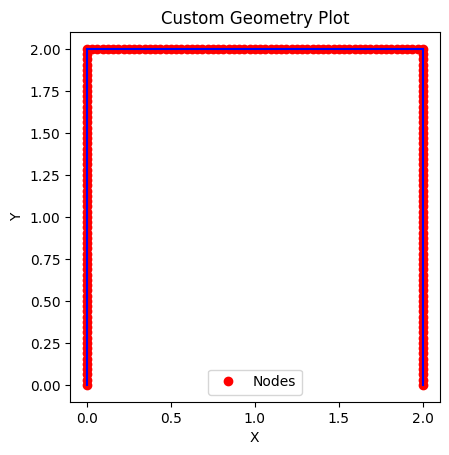

Solving time [s]: 0.0049
######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.98147011e-21
 -9.92911555e-07  2.16004753e-20 -6.93215545e-21 -1.98582311e-06
 -6.59702248e-20 -7.80737837e-21 -2.97873466e-06 -1.11229119e-19
 -7.83606854e-21 -3.97164622e-06 -1.20148322e-19 -7.76206055e-21
 -4.96455777e-06 -1.17801801e-19 -7.76276734e-21 -5.95746933e-06
 -1.15366576e-19 -7.81444027e-21 -6.95038088e-06 -1.14539968e-19
 -7.87966006e-21 -7.94329244e-06 -1.14499578e-19 -7.94392117e-21
 -8.93620399e-06 -1.14601322e-19 -8.00573588e-21 -9.92911555e-06
 -1.14656148e-19 -8.06651519e-21 -1.09220271e-05 -1.14667588e-19
 -8.12715538e-21 -1.19149387e-05 -1.14665051e-19 -8.18788046e-21
 -1.29078502e-05 -1.14662155e-19 -8.24866674e-21 -1.39007618e-05
 -1.14661135e-19 -8.30946999e-21 -1.48936733e-05 -1.14661069e-19
 -8.37027243e-21 -1.58865849e-05 -1.14661187e-19 -8.43107200e-21
 -1.68794964e-05 -1.14661253e-19 -8.49187030e-21 -1.78724080e-05
 -1.146

In [4]:
# Generate the geometry
nodes, elements, supp, load = mesh.generate_portic_geometry(num_elements_per_edge, L)

# Plot the nodes
mesh.plot_nodes(nodes, elements)

# Solve the problem using the VEM
uh_vem, K, f, solving_time = solve_vem.solve_1d(nodes, elements, supp, E, A, I, load, q, t)

## Measuring Solving and Inference Time

In [ ]:
# Measuring time for solving using VEM
solving_time_list = []
for _ in range(time_sampling_size):
    uh_vem, K, f, solving_time = solve_vem.solve_1d(nodes, elements, supp, E, A, I, load, q, t)
    solving_time_list.append(solving_time)

print("Mean solving time: ", np.mean(solving_time_list))
print("Std Deviation: ", np.std(solving_time_list))

In [ ]:
# Hyperparameters
num_epochs = 800

# Layers definition
nodes_layers = [128, 256, 512, 512, 512, 512]  # Layers for nodes sub-network
material_layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 2048] # Layers for materials sub-network
final_layers = [1024, 1024, 1024, 1024]  # Layers for final combination network

# Training pipeline
(input_vector, 
 model, 
 total_loss_values, 
 loss_values, 
 material_loss_values, 
 sobolev_loss_values, 
 alpha_values_values) = neural.train_material_portic(
    epochs=num_epochs,
    nodes=nodes,
    K=K,
    f=f,
    E=E,
    A=A,
    I=I,
    uh_vem=uh_vem,
    nodes_layers=nodes_layers,
    material_layers=material_layers,
    final_layers=final_layers,
    verbose=True,
    noramlize_inputs=True,
    network_type="material"
 )

# Setting up material parameters
material_params = torch.tensor([E , A , I ], dtype=torch.float32)
# nodes = torch.tensor(nodes.flatten(), dtype=torch.float32)
nodes, material_params = neural.normalize_inputs(nodes, material_params)

# Measuring time spent for inference
inference_time_list = []
for _ in range(time_sampling_size):
    predicted_displacements, l2_error, energy_error, h1_error, inference_time = neural.test_portic(
        nodes=nodes,
        material_params=material_params,
        model=model,
        uh_vem=uh_vem,
        K=K,
        f=f,
        concatanate=False,
        verbose=False
    )
    inference_time_list.append(inference_time)

print("Mean inference time: ", np.mean(inference_time_list))
print("Std Deviation: ", np.std(inference_time_list))

The model refers to the disaplcement field and the loss function regards to the calculation of the residual taking in consideration the Virtual Element Method's stiffness matrix and load vector.

## Influence of Deep Layers in the Generalization

In [ ]:
# Hyperparameters
num_epochs = 800

# Reading the json with respective layers
with open("data/layers_20240929.json", "r") as data:
    layers = json.load(data)

results = []

for i,layer in enumerate(layers):

    # Define the number of elements per edge
    num_elements_per_edge = 128

    # geometry data
    L = 2.0
    I = 1e-4
    A = 1

    # material data
    E = 27e6

    # Define load parameters
    q = -400
    t = 0


    # Generate the geometry
    nodes, elements, supp, load = mesh.generate_portic_geometry(num_elements_per_edge, L)

    # Solve the problem using the VEM
    uh_vem, K, f, solving_time = solve_vem.solve_1d(nodes, elements, supp, E, A, I, load, q, t, verbose=False)

    print(f"Training and testing layer {i+1}/{len(layers)}")
    # Defining layers
    nodes_layers = list(layer["node_layers"])
    material_layers = list(layer["material_layers"])
    final_layers = list(layer["final_layers"])

    # Training pipeline
    (input_vector, 
    model, 
    total_loss_values, 
    loss_values, 
    material_loss_values, 
    sobolev_loss_values, 
    alpha_values_values) = neural.train_material_portic(
        epochs=num_epochs,
        nodes=nodes,
        K=K,
        f=f,
        E=E,
        A=A,
        I=I,
        uh_vem=uh_vem,
        nodes_layers=nodes_layers,
        material_layers=material_layers,
        final_layers=final_layers,
        verbose=False,
        noramlize_inputs=True,
        network_type="material"
    )

    # Setting up material parameters
    material_params = torch.tensor([E , A , I ], dtype=torch.float32)
    nodes, material_params = neural.normalize_inputs(nodes, material_params)

    # Testing the model with default parameters
    predicted_displacements, l2_error_default, energy_error_default, h1_error_default, inference_time_default = neural.test_portic(
        nodes=nodes,
        material_params=material_params,
        model=model,
        uh_vem=uh_vem,
        K=K,
        f=f,
        concatanate=False,
        verbose=False
    )

    # Setting up new material parameters
    I_new = 1e-4
    A_new = 2
    E_new = 110e5

    # Generate the geometry
    nodes, elements, supp, load = mesh.generate_portic_geometry(num_elements_per_edge, L)

    # Solve the problem using the VEM
    uh_vem, K, f, solving_time = solve_vem.solve_1d(nodes, elements, supp, E_new, A_new, I_new, load, q, t)

    # Testing the model with new parameters
    material_params = torch.tensor([E_new , A_new , I_new], dtype=torch.float32)
    nodes = torch.tensor(nodes.flatten(), dtype=torch.float32)
    nodes, material_params = neural.normalize_inputs(nodes, material_params)
    predicted_displacements, l2_error_new, energy_error_new, h1_error_new, inference_time_new = neural.test_portic(
        nodes=nodes,
        material_params=material_params,
        model=model,
        uh_vem=uh_vem,
        K=K,
        f=f,
        concatanate=False,
        verbose=False
    )

    # Setting up new material parameters
    I_new_2 = 1e-4
    A_new_2 = 3
    E_new_2 = 80e3

    # Generate the geometry
    nodes, elements, supp, load = mesh.generate_portic_geometry(num_elements_per_edge, L)

    # Solve the problem using the VEM
    uh_vem, K, f, solving_time = solve_vem.solve_1d(nodes, elements, supp, E_new_2, A_new_2, I_new_2, load, q, t)

    # Testing the model with new parameters
    material_params = torch.tensor([E_new_2 , A_new_2 , I_new_2], dtype=torch.float32)
    nodes = torch.tensor(nodes.flatten(), dtype=torch.float32)
    nodes, material_params = neural.normalize_inputs(nodes, material_params)
    predicted_displacements, l2_error_new, energy_error_new, h1_error_new, inference_time_new = neural.test_portic(
        nodes=nodes,
        material_params=material_params,
        model=model,
        uh_vem=uh_vem,
        K=K,
        f=f,
        concatanate=False,
        verbose=False
    )

    results.append({
        "tag": layer["tag"],
        "l2_error_default": l2_error_default,
        "energy_error_default": energy_error_default,
        "h1_error_default": h1_error_default,
        "inferece_time_default": inference_time_default,
        "l2_error_new": l2_error_new,
        "energy_error_new": energy_error_new,
        "h1_error_new": h1_error_new,
        "inferece_time_new": inference_time_new,
        "l2_error_new_2": l2_error_new,
        "energy_error_new_2": energy_error_new,
        "h1_error_new_2": h1_error_new,
        "inferece_time_new_2": inference_time_new,
    })

In [ ]:
# Save results in a dataframe
results_df = pd.DataFrame(results)
results_df.to_csv("data/output/results_20240929.csv", index=False)

## Training and Testing Pipeline

In [ ]:
# Hyperparameters
num_epochs = 800

# Layers definition
nodes_layers = [128, 256, 512, 512, 512, 512]  # Layers for nodes sub-network
material_layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 2048] # Layers for materials sub-network
final_layers = [1024, 1024, 1024, 1024]  # Layers for final combination network

# Training pipeline
(input_vector, 
 model, 
 total_loss_values, 
 loss_values, 
 material_loss_values, 
 sobolev_loss_values, 
 alpha_values_values) = neural.train_material_portic(
    epochs=num_epochs,
    nodes=nodes,
    K=K,
    f=f,
    E=E,
    A=A,
    I=I,
    uh_vem=uh_vem,
    nodes_layers=nodes_layers,
    material_layers=material_layers,
    final_layers=final_layers,
    verbose=True,
    noramlize_inputs=True,
    network_type="material",
    batch_norm=False
 )

Given the reference displacement field calculated by the Virtual Element Method, a displacemente field is supposed to be calculated considering the material parameters contributions to it.

In [ ]:
filtered_total_loss = total_loss_values[150:]
plt.plot(filtered_total_loss)
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

filtered_loss = loss_values[150:]
plt.plot(filtered_loss)
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

filtered_material_loss = material_loss_values[150:]
plt.plot(filtered_material_loss)
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Material Loss over Epochs')
plt.show()

filtered_sobolev_loss = sobolev_loss_values[150:]
plt.plot(filtered_sobolev_loss)
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Sobolev Loss over Epochs')
plt.show()

filtered_alpha_values = alpha_values_values[150:]
plt.plot(filtered_alpha_values)
plt.xlabel('Epochs ')
plt.ylabel('alpha')
plt.title('Alpha Values over Epochs')
plt.show()

In [ ]:
material_params = torch.tensor([E , A , I ], dtype=torch.float32)
# nodes = torch.tensor(nodes.flatten(), dtype=torch.float32)
nodes, material_params = neural.normalize_inputs(nodes, material_params)

predicted_displacements, l2_error, energy_error, h1_error, inference_time = neural.test_portic(
    nodes=nodes,
    material_params=material_params,
    model=model,
    uh_vem=uh_vem,
    K=K,
    f=f,
    concatanate=False
)

In [ ]:
# New geometry parameter
I_new = 1e-4
A_new = 2
E_new = 110e5

# Generate the geometry
nodes, elements, supp, load = mesh.generate_portic_geometry(num_elements_per_edge, L)

# Solve the problem using the VEM
uh_vem, K, f, solving_time = solve_vem.solve_1d(nodes, elements, supp, E_new, A_new, I_new, load, q, t)

# Testing the model with new parameters
material_params = torch.tensor([E_new , A_new , I_new ], dtype=torch.float32)
nodes = torch.tensor(nodes.flatten(), dtype=torch.float32)
nodes, material_params = neural.normalize_inputs(nodes, material_params)
predicted_displacements, l2_error, energy_error, h1_error, inference_time = neural.test_portic(
    nodes=nodes,
    material_params=material_params,
    model=model,
    uh_vem=uh_vem,
    K=K,
    f=f,
    concatanate=False,
    verbose=True
)

In [ ]:
# New geometry parameter
I_new_2 = 1e-4
A_new_2 = 3
E_new_2 = 80e3

# Generate the geometry
nodes, elements, supp, load = mesh.generate_portic_geometry(num_elements_per_edge, L)

# Solve the problem using the VEM
uh_vem, K, f, solving_time = solve_vem.solve_1d(nodes, elements, supp, E_new_2, A_new_2, I_new_2, load, q, t)

# Testing the model with new parameters
material_params = torch.tensor([E_new_2 , A_new_2 , I_new_2 ], dtype=torch.float32)
nodes = torch.tensor(nodes.flatten(), dtype=torch.float32)
nodes, material_params = neural.normalize_inputs(nodes, material_params)
predicted_displacements, l2_error, energy_error, h1_error, inference_time = neural.test_portic(
    nodes=nodes,
    material_params=material_params,
    model=model,
    uh_vem=uh_vem,
    K=K,
    f=f,
    concatanate=False,
    verbose=True
)

## GradNorm

In [ ]:
import core.grad_norm as gn
import core.neural_backend as neural

In [ ]:
ndof = 3 * len(nodes)
input_dim = 2*len(nodes) + 3

input_dim_nodes = 2*len(nodes)
input_dim_materials = 3

# Original material parameters
material_params_1 = torch.tensor([E, A, I], dtype=torch.float32)

# Perturbed material parameters (slightly changed)
material_params_2 = torch.tensor([E *1.1, A * 1.1, I * 0.9], dtype=torch.float32)

nodes, material_params_1 = neural.normalize_inputs(nodes, material_params_1)
_, material_params_2 = neural.normalize_inputs(nodes, material_params_2)

nodes = nodes.flatten()
nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

input_vector = torch.cat([nodes, material_params_1])

lr = 1e-3

In [ ]:
# Layers definition
nodes_layers = [128, 256, 512, 512, 512, 512]  # Layers for nodes sub-network
material_layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 2048] # Layers for materials sub-network
final_layers = [1024, 1024, 1024, 1024]  # Layers for final combination network

model = neural.BeamApproximatorWithMaterials(
                input_dim_nodes=input_dim_nodes, 
                input_dim_materials=input_dim_materials, 
                nodes_layers=nodes_layers, 
                material_layers=material_layers, 
                final_layers=final_layers, 
                ndof=ndof)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

K = torch.tensor(K, dtype=torch.float32, requires_grad=True)
f = torch.tensor(f, dtype=torch.float32, requires_grad=True)

total_loss_values = []
loss_values = []
material_loss_values = []
sobolev_loss_values = []
alpha_values_values = []

In [ ]:
# Initialize loss weights
loss_weights = torch.ones(3, requires_grad=True)  # We have 3 tasks: loss, sobolev_loss, and material_penalty

# Hyperparameters
num_epochs = 200
concatanate = False

# Initialize optimizers (including the loss_weights as parameters)
optimizer = torch.optim.Adam(list(model.parameters()) + [loss_weights], lr=1e-3)
optimizer_w = torch.optim.SGD([loss_weights], lr=1e-3)

# Initialize lists to store loss values
total_loss_values, loss_values, material_loss_values, sobolev_loss_values, alpha_values_values = [], [], [], [], []

# Enable anomaly detection for debugging
torch.autograd.set_detect_anomaly(True)

# Loop through epochs
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass
    uh = model(nodes, material_params_1)
    
    # Compute individual losses
    loss = loss_function.compute_loss_with_uh(uh_vem, uh)
    sobolev_loss = loss_function.compute_sobolev_loss(model, nodes, material_params_1, loss, concatanate)
    material_penalty = loss_function.compute_material_penalty(model, nodes, material_params_1, material_params_2, concatanate) * 1e10

    # Weighted sum of losses (with GradNorm weights)
    weighted_losses = [
        loss_weights[0] * loss, 
        loss_weights[1] * sobolev_loss, 
        loss_weights[2] * material_penalty
    ]

    # Store the initial loss weights
    if epoch == 0:
        initial_loss_weights = [
            loss_weights[0] * loss, 
            loss_weights[1] * sobolev_loss, 
            loss_weights[2] * material_penalty
        ]

    # Calculate the gradient norms for each task
    grad_norms = gn.calculate_gradient_norm(model, weighted_losses)
    tilde_losses = [gn.compute_loss_ratio(weighted_losses[i].item(), initial_loss_weights[i].item()) for i in range(len(weighted_losses))]

    # Compute the grad norm loss
    loss_grad = gn.compute_grad_norm_loss(grad_norms, tilde_losses, 100)

    # Backpropagation of the gradient loss (update the grad_loss weights)
    loss_grad.backward(retain_graph=True)

    # Step 1: Perform the optimizer step to update the task weights using the gradient loss
    optimizer_w.step()

    # Step 2: Compute the total loss (sum of the weighted loss)
    total_loss = loss_weights[0] * loss + loss_weights[1] * sobolev_loss + loss_weights[2] * material_penalty

    # Backpropagation for the model weights using total loss
    total_loss.backward()

    # Step 3: Perform the optimizer step to update the model weights using the total loss
    optimizer.step()

    # Step 4: Renormalize the loss weights (no in-place operation)
    T = len(weighted_losses)
    sum_w = torch.sum(loss_weights).item()

    # Instead of modifying in-place, re-assign to a new tensor
    with torch.no_grad():
        loss_weights.copy_((loss_weights / sum_w) * T)  # Use .copy_ to avoid creating new tensors and keep gradients

    # Store losses for analysis
    if epoch > 0:
        total_loss_values.append(total_loss.item())
        loss_values.append(loss_weights[0].item()*loss.item())
        material_loss_values.append(loss_weights[2].item()*material_penalty.item())
        sobolev_loss_values.append(loss_weights[1].item()*sobolev_loss.item())

    # Print progress
    print(f'Epoch: {epoch + 1}, Total Loss: {total_loss.item()}, Loss Weights: {loss_weights.detach().numpy()}')

In [ ]:
filtered_total_loss = total_loss_values[150:]
plt.plot(filtered_total_loss)
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

filtered_loss = loss_values[150:]
plt.plot(filtered_loss)
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.show()

filtered_material_loss = material_loss_values[150:]
plt.plot(filtered_material_loss)
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Material Loss over Epochs')
plt.show()

filtered_sobolev_loss = sobolev_loss_values[150:]
plt.plot(filtered_sobolev_loss)
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.title('Sobolev Loss over Epochs')
plt.show()

filtered_alpha_values = alpha_values_values[150:]
plt.plot(filtered_alpha_values)
plt.xlabel('Epochs ')
plt.ylabel('alpha')
plt.title('Alpha Values over Epochs')
plt.show()

In [ ]:
# New geometry parameter
I_new = 1e-4
A_new = 2
E_new = 110e5

# Generate the geometry
nodes, elements, supp, load = mesh.generate_portic_geometry(num_elements_per_edge, L)

# Solve the problem using the VEM
uh_vem, K, f, solving_time = solve_vem.solve_1d(nodes, elements, supp, E_new, A_new, I_new, load, q, t)

# Testing the model with new parameters
material_params = torch.tensor([E_new , A_new , I_new ], dtype=torch.float32)
nodes = torch.tensor(nodes.flatten(), dtype=torch.float32)
nodes, material_params = neural.normalize_inputs(nodes, material_params)
predicted_displacements, l2_error, energy_error, h1_error, inference_time = neural.test_portic(
    nodes=nodes,
    material_params=material_params,
    model=model,
    uh_vem=uh_vem,
    K=K,
    f=f,
    concatanate=False,
    verbose=True
)

In [ ]:
# New geometry parameter
I_new_2 = 1e-4
A_new_2 = 3
E_new_2 = 80e2

# Generate the geometry
nodes, elements, supp, load = mesh.generate_portic_geometry(num_elements_per_edge, L)

# Solve the problem using the VEM
uh_vem, K, f, solving_time = solve_vem.solve_1d(nodes, elements, supp, E_new_2, A_new_2, I_new_2, load, q, t)

# Testing the model with new parameters
material_params = torch.tensor([E_new_2 , A_new_2 , I_new_2 ], dtype=torch.float32)
nodes = torch.tensor(nodes.flatten(), dtype=torch.float32)
nodes, material_params = neural.normalize_inputs(nodes, material_params)
predicted_displacements, l2_error, energy_error, h1_error, inference_time = neural.test_portic(
    nodes=nodes,
    material_params=material_params,
    model=model,
    uh_vem=uh_vem,
    K=K,
    f=f,
    concatanate=False,
    verbose=True
)

## Using few material data

In [5]:
import core.grad_norm as gn
import core.neural_backend as neural
from utils.helpers import generate_beam_parameters

In [6]:
ndof = 3 * len(nodes)
input_dim = 2*len(nodes) + 3

input_dim_nodes = 2*len(nodes)
input_dim_materials = 3

# Original material parameters
material_params_1 = torch.tensor([E, A, I], dtype=torch.float32)

# Perturbed material parameters (slightly changed)
material_params_2 = torch.tensor([E *1.1, A * 1.1, I * 0.9], dtype=torch.float32)

nodes, material_params_1 = neural.normalize_inputs(nodes, material_params_1)
_, material_params_2 = neural.normalize_inputs(nodes, material_params_2)

nodes = nodes.flatten()
nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

input_vector = torch.cat([nodes, material_params_1])

lr = 1e-3

/Users/pauloakira/Main/_repos/ai-pinn/core/neural_backend.py:203: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_nodes = torch.tensor(normalized_nodes, dtype=torch.float32, requires_grad=True)
/Users/pauloakira/Main/_repos/ai-pinn/core/neural_backend.py:204: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  normalized_material_params = torch.tensor(normalized_material_params, dtype=torch.float32, requires_grad=True)
/var/folders/r8/9jdwwqz11dq7_2m0n6cds_k40000gn/T/ipykernel_45938/2093153052.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(source

In [7]:
# Layers definition
nodes_layers = [128, 256, 512, 512, 512, 512]  # Layers for nodes sub-network
material_layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 2048, 4096, 4096, 2048, 2048, 1024, 1024, 1024, 1024, 512, 512] # Layers for materials sub-network
final_layers = [1024, 1024, 1024, 1024, 1024, 1024] # Layers for final combination network

model = neural.BeamApproximatorWithMaterials(
                input_dim_nodes=input_dim_nodes, 
                input_dim_materials=input_dim_materials, 
                nodes_layers=nodes_layers, 
                material_layers=material_layers, 
                final_layers=final_layers, 
                ndof=ndof).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

K = torch.tensor(K, dtype=torch.float32, requires_grad=True).to(device)
f = torch.tensor(f, dtype=torch.float32, requires_grad=True).to(device)

total_loss_values = []
loss_values = []
material_loss_values = []
sobolev_loss_values = []
alpha_values_values = []

/opt/anaconda3/envs/ml-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def z_score_normalize(value, mean_val, std_val):
    """Z-score normalization."""
    return (value - mean_val) / std_val

def generate_beam_dataset(elastic_module_range: list, inertia_moment_range: list, area_range: list, num_samples: int):
    """
    Function to generate a dataset of beam parameters with z-score normalized material properties.
    """
    # Initialize lists to store the dataset
    dataset = []

    # Generate the material parameters
    params = generate_beam_parameters(elastic_module_range, inertia_moment_range, area_range, num_samples)

    # Extract E, I, and A values for normalization
    E_values = [param['E'] for param in params]
    I_values = [param['I'] for param in params]
    A_values = [param['A'] for param in params]

    # Calculate mean and standard deviation
    E_mean, E_std = torch.mean(torch.tensor(E_values)), torch.std(torch.tensor(E_values))
    I_mean, I_std = torch.mean(torch.tensor(I_values)), torch.std(torch.tensor(I_values))
    A_mean, A_std = torch.mean(torch.tensor(A_values)), torch.std(torch.tensor(A_values))

    # Normalize each parameter using z-score normalization
    for i in range(num_samples):
        E, I, A = params[i]['E'], params[i]['I'], params[i]['A']

        # Z-score normalization
        E_norm = z_score_normalize(E, E_mean, E_std)
        I_norm = z_score_normalize(I, I_mean, I_std)
        A_norm = z_score_normalize(A, A_mean, A_std)

        # Generate the geometry
        nodes, elements, supp, load = mesh.generate_portic_geometry(num_elements_per_edge, L)

        # Solve the problem using the VEM
        uh_vem, K, f, solving_time = solve_vem.solve_1d(nodes, elements, supp, E, A, I, load, q, t, verbose=False)

        # Convert nodes to tensor
        nodes = nodes.flatten()
        nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)

        # Store the dataset
        dataset.append({
            "nodes": nodes,
            "elements": elements,
            "supp": supp,
            "load": load,
            "uh_vem": uh_vem,
            "K": K,
            "f": f,
            "material_params": torch.tensor([E_norm, A_norm, I_norm], dtype=torch.float32),
            "distorted_material_params": torch.tensor([z_score_normalize(E * 1.3, E_mean, E_std), 
                                                      z_score_normalize(A * 1.1, A_mean, A_std), 
                                                      z_score_normalize(I * 0.3, I_mean, I_std)], dtype=torch.float32)
        })

    return dataset

In [ ]:
# Initialize loss weights
loss_weights = torch.ones(3, requires_grad=True, device=device)  # We have 3 tasks: loss, sobolev_loss, and material_penalty 

# Hyperparameters
num_epochs = 80
concatenate = False

# Initialize optimizers (including the loss_weights as parameters)
optimizer = torch.optim.Adam(list(model.parameters()) + [loss_weights], lr=1e-3)
optimizer_w = torch.optim.SGD([loss_weights], lr=1e-3)

# Initialize lists to store loss values
total_loss_values, loss_values, material_loss_values, sobolev_loss_values, alpha_values_values = [], [], [], [], []

# Enable anomaly detection for debugging
torch.autograd.set_detect_anomaly(True)

# Different material property configurations (for example, different E, I, A values)
dataset = generate_beam_dataset([1e6, 210e9], [1e-6, 1e-3], [1, 10], 100)

In [ ]:
# Loop through each material in the dataset
for i,data in enumerate(dataset):
    
    material_params_1 = data['material_params']
    material_params_2 = data['distorted_material_params']
    nodes = data['nodes']
    uh_vem = data['uh_vem']

    nodes, material_params_1 = neural.normalize_inputs(nodes, material_params_1)
    _, material_params_2 = neural.normalize_inputs(nodes, material_params_2)

    nodes = nodes.flatten()
    nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True)
    
    # Loop through epochs for the same material
    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # Forward pass using the current material parameters
        uh = model(nodes, material_params_1)  # Adjust input to include material params

        # Compute individual losses
        loss = loss_function.compute_loss_with_uh(uh_vem, uh)
        sobolev_loss = loss_function.compute_sobolev_loss(model, nodes, material_params_1, loss, concatenate)
        material_penalty = loss_function.compute_material_penalty(model, nodes, material_params_1, material_params_2, concatenate) 

        # Weighted sum of losses (with GradNorm weights)
        weighted_losses = [
            loss_weights[0] * loss, 
            loss_weights[1] * sobolev_loss, 
            loss_weights[2] * material_penalty
        ]

        # Store the initial loss weights
        if epoch == 0:
            initial_loss_weights = [
                loss_weights[0] * loss, 
                loss_weights[1] * sobolev_loss, 
                loss_weights[2] * material_penalty
            ]

        # Calculate the gradient norms for each task
        grad_norms = gn.calculate_gradient_norm(model, weighted_losses)
        tilde_losses = [gn.compute_loss_ratio(weighted_losses[i].item(), initial_loss_weights[i].item()) for i in range(len(weighted_losses))]

        # Compute the grad norm loss
        loss_grad = gn.compute_grad_norm_loss(grad_norms, tilde_losses, alpha=100)

        # Backpropagation of the gradient loss (update the grad_loss weights)
        loss_grad.backward(retain_graph=True)

        # Step 1: Perform the optimizer step to update the task weights using the gradient loss
        optimizer_w.step()

        # Step 2: Compute the total loss (sum of the weighted loss)
        total_loss = loss_weights[0] * loss + loss_weights[1] * sobolev_loss + loss_weights[2] * material_penalty

        # Perform gradient clipping and check for NaN/Inf before backpropagation
        if torch.isnan(total_loss).any() or torch.isinf(total_loss).any():
            print(f"NaN or Inf detected in total_loss at epoch {epoch}")
            continue
        
        # Break if the total loss is too high
        if abs(total_loss.item()) > 100.0 and epoch > 0:
            break

        # Backpropagation for the model weights using total loss
        total_loss.backward()

        # Step 3: Perform the optimizer step to update the model weights using the total loss
        optimizer.step()

        # Step 4: Renormalize the loss weights (no in-place operation)
        T = len(weighted_losses)
        sum_w = torch.sum(loss_weights).item()

        # Instead of modifying in-place, re-assign to a new tensor
        with torch.no_grad():
            loss_weights.copy_((loss_weights / sum_w) * T)  # Use .copy_ to avoid creating new tensors and keep gradients

        # Store losses for analysis
        if epoch > 1:
            total_loss_values.append(total_loss.item())
            loss_values.append(loss_weights[0].item()*loss.item())
            material_loss_values.append(loss_weights[2].item()*material_penalty.item())
            sobolev_loss_values.append(loss_weights[1].item()*sobolev_loss.item())

        # Print progress
        print(f'Material {i+1}: {material_params_1}, Epoch: {epoch + 1}, Total Loss: {total_loss.item()}, Loss Weights: {loss_weights.detach().numpy()}')
        
    # Break if the total loss is too high
    if abs(total_loss.item()) > 1.0:
        break

In [ ]:
## CLASSICAL APPROACH ##

print(nodes.shape)
print(type(nodes))

# Loop through epochs (train across all materials in each epoch)
for epoch in range(num_epochs):
    optimizer.zero_grad()
    print(f"--> Epoch {epoch + 1}")
    
    # Loop through each material in the dataset
    for i, data in enumerate(dataset):
        
        # Move material parameters and nodes to the correct device
        material_params_1 = data['material_params']
        material_params_2 = data['distorted_material_params']
        nodes = data['nodes']
        uh_vem = data['uh_vem']

        # Normalize inputs
        nodes, material_params_1 = neural.normalize_inputs(nodes, material_params_1)
        _, material_params_2 = neural.normalize_inputs(nodes, material_params_2)

        material_params_1 = material_params_1.to(device)
        material_params_2 = material_params_2.to(device)

        nodes = nodes.flatten()
        nodes = torch.tensor(nodes, dtype=torch.float32, requires_grad=True).to(device)
        
        # Forward pass using the current material parameters
        uh = model(nodes, material_params_1.to(device))  # Adjust input to include material params
        uh_vem = torch.tensor(uh_vem, dtype=torch.float32, requires_grad=True).to(device)
        # Compute individual losses
        loss = loss_function.compute_loss_with_uh(uh_vem, uh).to(device)
        sobolev_loss = loss_function.compute_sobolev_loss(model, nodes, material_params_1, loss, concatenate).to(device)
        material_penalty = loss_function.compute_material_penalty(model, nodes, material_params_1, material_params_2, concatenate).to(device) * 1e10

        # Weighted sum of losses (with GradNorm weights)
        weighted_losses = [
            loss_weights[0] * loss, 
            loss_weights[1] * sobolev_loss, 
            loss_weights[2] * material_penalty
        ]

        # Store the initial loss weights
        if epoch == 0 and i == 0:
            initial_loss_weights = [
                loss_weights[0] * loss, 
                loss_weights[1] * sobolev_loss, 
                loss_weights[2] * material_penalty
            ]

        # Calculate the gradient norms for each task
        grad_norms = gn.calculate_gradient_norm(model, weighted_losses)
        tilde_losses = [gn.compute_loss_ratio(weighted_losses[i].item(), initial_loss_weights[i].item()) for i in range(len(weighted_losses))]

        # Compute the grad norm loss
        loss_grad = gn.compute_grad_norm_loss(grad_norms, tilde_losses, alpha=100)

        # Backpropagation of the gradient loss (update the grad_loss weights)
        loss_grad.backward(retain_graph=True)

        # Step 1: Perform the optimizer step to update the task weights using the gradient loss
        optimizer_w.step()

        # Step 2: Compute the total loss (sum of the weighted loss)
        total_loss = loss_weights[0] * loss + loss_weights[1] * sobolev_loss + loss_weights[2] * material_penalty

        # Backpropagation for the model weights using total loss
        total_loss.backward()

        # Step 3: Perform the optimizer step to update the model weights using the total loss
        optimizer.step()

        # Step 4: Renormalize the loss weights (no in-place operation)
        T = len(weighted_losses)
        sum_w = torch.sum(loss_weights).item()

        # Instead of modifying in-place, re-assign to a new tensor
        with torch.no_grad():
            loss_weights.copy_((loss_weights / sum_w) * T)

        # Store losses for analysis
        if epoch > 0:
            total_loss_values.append(total_loss.item())
            loss_values.append(loss_weights[0].item() * loss.item())
            material_loss_values.append(loss_weights[2].item() * material_penalty.item())
            sobolev_loss_values.append(loss_weights[1].item() * sobolev_loss.item())

        # Print progress
        print(f'Material {i+1}: {material_params_1}, Epoch: {epoch + 1}, Total Loss: {total_loss.item()}, Loss Weights: {loss_weights.detach().cpu().numpy()}')

    print("Finished epoch\n")

In [ ]:
# New geometry parameter
I_new = 1e-4
A_new = 1
E_new = 110e6

# Generate the geometry
nodes, elements, supp, load = mesh.generate_portic_geometry(num_elements_per_edge, L)

# Solve the problem using the VEM
uh_vem, K, f, solving_time = solve_vem.solve_1d(nodes, elements, supp, E_new, A_new, I_new, load, q, t)

# Testing the model with new parameters
material_params = torch.tensor([E_new , A_new , I_new ], dtype=torch.float32)
nodes = torch.tensor(nodes.flatten(), dtype=torch.float32)
nodes, material_params = neural.normalize_inputs(nodes, material_params)
predicted_displacements, l2_error, energy_error, h1_error, inference_time = neural.test_portic(
    nodes=nodes,
    material_params=material_params,
    model=model,
    uh_vem=uh_vem,
    K=K,
    f=f,
    concatanate=False,
    verbose=True
)

In [ ]:
# Save the trained model
torch.save(model.state_dict(), "data/models/neural_vem_64.pth")

In [24]:
nodes_layers = [128, 256, 512, 512, 512, 512]  # Layers for nodes sub-network
material_layers = [128, 128, 256, 256, 512, 512, 512, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 1024, 2048, 2048, 4096, 4096, 2048, 2048, 1024, 1024, 1024, 1024, 512, 512] # Layers for materials sub-network
final_layers = [1024, 1024, 1024, 1024, 1024, 1024] # Layers for final combination network

# Create a new instance of the model (with the same architecture)
loaded_model = neural.BeamApproximatorWithMaterials(
    input_dim_nodes=input_dim_nodes, 
    input_dim_materials=input_dim_materials, 
    nodes_layers=nodes_layers, 
    material_layers=material_layers, 
    final_layers=final_layers, 
    ndof=ndof
)

# Load the saved model state
loaded_model.load_state_dict(torch.load("data/models/neural_vem_64.pth"))

# Set the model to evaluation mode (important for inference)
loaded_model.eval()

BeamApproximatorWithMaterials(
  (nodes_in): Linear(in_features=386, out_features=128, bias=True)
  (nodes_hidden): ModuleList(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=512, bias=True)
    (2-4): 3 x Linear(in_features=512, out_features=512, bias=True)
  )
  (nodes_out): Linear(in_features=512, out_features=579, bias=True)
  (materials_in): Linear(in_features=3, out_features=128, bias=True)
  (materials_hidden): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4-5): 2 x Linear(in_features=512, out_features=512, bias=True)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7-15): 9 x Linear(in_features=1024, out_features=1024, bias=True)
    (16): Linear(in_features=1024, out_features=2048, b

In [26]:
# New geometry parameters for inference
I_new = 1e-4
A_new = 1
E_new = 110e6

# Generate the geometry
nodes, elements, supp, load = mesh.generate_portic_geometry(num_elements_per_edge, L)

# Solve the problem using VEM
uh_vem, K, f, solving_time = solve_vem.solve_1d(nodes, elements, supp, E_new, A_new, I_new, load, q, t)

# Prepare the input for the model
material_params = torch.tensor([E_new, A_new, I_new], dtype=torch.float32)
nodes = torch.tensor(nodes.flatten(), dtype=torch.float32)

# Normalize inputs before passing to the model
nodes, material_params = neural.normalize_inputs(nodes, material_params)

# Test the model using the new material parameters
predicted_displacements, l2_error, energy_error, h1_error, inference_time = neural.test_portic(
    nodes=nodes,
    material_params=material_params,
    model=loaded_model,  # Use the loaded model for inference
    uh_vem=uh_vem,
    K=K,
    f=f,
    concatanate=False,
    verbose=True
)

Solving time [s]: 0.0132
######################### Beam ##########################
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  5.22081181e-22
 -2.43714654e-07 -2.95856192e-21  9.02978408e-22 -4.87429309e-07
  9.03577313e-21  9.99604850e-22 -7.31143963e-07  1.52347683e-20
  9.80283862e-22 -9.74858618e-07  1.64564087e-20  9.46896571e-22
 -1.21857327e-06  1.61350116e-20  9.23742772e-22 -1.46228793e-06
  1.58014652e-20  9.07569675e-22 -1.70600258e-06  1.56882467e-20
  8.93252056e-22 -1.94971724e-06  1.56827146e-20  8.78803132e-22
 -2.19343189e-06  1.56966503e-20  8.64019128e-22 -2.43714654e-06
  1.57041596e-20  8.49093308e-22 -2.68086120e-06  1.57057266e-20
  8.34148434e-22 -2.92457585e-06  1.57053791e-20  8.19215187e-22
 -3.16829051e-06  1.57049824e-20  8.04290323e-22 -3.41200516e-06
  1.57048426e-20  7.89367783e-22 -3.65571982e-06  1.57048336e-20
  7.74445132e-22 -3.89943447e-06  1.57048498e-20  7.59522086e-22
 -4.14314912e-06  1.57048588e-20  7.44598868e-22 -4.38686378e-06
  1.570

In [ ]:
inference_time_list = []
for _ in range(time_sampling_size):
    # Test the model using the new material parameters
    predicted_displacements, l2_error, energy_error, h1_error, inference_time = neural.test_portic(
        nodes=nodes,
        material_params=material_params,
        model=loaded_model,  # Use the loaded model for inference
        uh_vem=uh_vem,
        K=K,
        f=f,
        concatanate=False,
        verbose=True
    )
    inference_time_list.append(inference_time)

print("Mean inference time: ", np.mean(inference_time_list))
print("Std Deviation: ", np.std(inference_time_list))

In [ ]:
from utils.helpers import read_disp_json, consolidate_json_in_dataset
import numpy as np
filename = "data/displacements_64_1.json_1731459229.json"

# Read the displacement data from the JSON file
u, E, I, A = read_disp_json(filename)

print(type(u))
print(type(u[0]))


In [ ]:
directory_path_name = "data/datasets/portic/"
consolidate_json_in_dataset(directory_path_name)

In [ ]:
from utils.datasets import generate_beam_dataset_from_json

result_filename = "data/consolidated_portic_data.json"
geometry_filename = "data/geometries/portic_64.json"
dataset = generate_beam_dataset_from_json(result_filename=result_filename, geometry_filename=geometry_filename)

In [1]:
from utils.helpers import read_disp_json, consolidate_json_in_dataset
directory_path_name = "data/datasets/beam/"
consolidate_json_in_dataset(directory_path_name, "consolidated_beam_data.json")

Data saved in data/consolidated_beam_data.json


In [1]:
from utils.datasets import generate_beam_dataset_from_json

result_filename = "data/consolidated_beam_data.json"
geometry_filename = "data/geometries/beam_64.json"
dataset = generate_beam_dataset_from_json(result_filename=result_filename, geometry_filename=geometry_filename)